**Write the names of all group members (max. 5 members)**:
- Hugo Belzil

When submitting your work, please follow closely the template below.

# Exercise 1 (Poisson GLM)

### Question 1.a

In [3]:
# Read csv file `freMTPL2freq.csv` (e.g. use pandas)
import numpy as np
import pandas as pd

data = pd.read_csv('freMTPL2freq.csv', delimiter=';')
print(data.head(70))

target_col = 'ClaimNb'
exposure_col = 'Exposure'

# The column Exposure was encoded with commas instead of columns (French!!!)
data[exposure_col] = data[exposure_col].astype(str).str.replace(',', '.', regex=False).astype(float)

feature_cols = [c for c in data.columns if c not in [target_col, exposure_col]]

x = data[feature_cols]
claims = data[target_col]
exposure = data[exposure_col]

    VehPower  VehAge  DrivAge  BonusMalus VehBrand   VehGas  Density Region  \
0          4       9       23         100       B6  Regular     7887    R31   
1          4       6       26         100       B6  Regular     2308    R31   
2          4       6       26         100       B6  Regular     2308    R31   
3          7       4       44          50       B6  Regular       37    R94   
4          5       2       29          90       B6  Regular      335    R91   
..       ...     ...      ...         ...      ...      ...      ...    ...   
65         6       2       71          54       B6  Regular     1541    R91   
66         8       9       56          50       B6   Diesel      272    R72   
67         5       3       52          50       B6  Regular      214    R26   
68         5       3       52          50       B6  Regular      214    R26   
69         5       6       40          60       B6  Regular    15703    R11   

   Exposure  ClaimNb  
0      0,76        0  
1    

In [5]:
# Train-test split
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

x_train, x_test, claims_train, claims_test, exp_train, exp_test = train_test_split(
    x, claims, exposure,
    test_size=0.1,
    random_state=42
)

# Obtaining categorical columns and printing them
categoric_columns = x.select_dtypes(include=['object', 'category']).columns.tolist()
num_cols = [c for c in x.columns if c not in categoric_columns]

print('Categoric columns in the dataset : ', categoric_columns, '\n')
print('Numerical columns in the dataset : ', num_cols)

# One-Hot encoding of data
ohe = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
ohe.fit(x_train[categoric_columns])

X_train_cat = ohe.transform(x_train[categoric_columns])
X_test_cat  = ohe.transform(x_test[categoric_columns])

# Scaling numerical variables
scaler_x = StandardScaler()
scaler_x.fit(x_train[num_cols])

X_train_num = scaler_x.transform(x_train[num_cols])
X_test_num  = scaler_x.transform(x_test[num_cols])

# Final design matrices
X_train_enc = np.hstack([X_train_num, X_train_cat])
X_test_enc  = np.hstack([X_test_num, X_test_cat])

# Train a Poisson GLM
from sklearn.linear_model import PoissonRegressor

# Convert claims to frequencies
y_train = claims_train / exp_train
y_test  = claims_test / exp_test

model_PR = PoissonRegressor(alpha=0, fit_intercept=True)
model_PR.fit(X_train_enc, y_train, sample_weight=exp_train)

# Predictions
y_pred_train = model_PR.predict(X_train_enc)
y_pred_test  = model_PR.predict(X_test_enc)

# Exposure-weighted Poisson deviance (Equation 2)
def weighted_poisson_deviance(y_true, y_pred, exposure):
    """
    L(D, θ̂) = 1 / sum(exp_i) * sum_i exp_i * ℓ(λ̂_i, y_i)
    with ℓ(λ̂, y) = 2(λ̂ - y - y log λ̂ + y log y)
    and convention 0*log(0) = 0
    """
    # Numerical stability
    y_pred = np.clip(y_pred, 1e-15, None)

    # Handle y log y term with convention 0 log 0 = 0
    y_true_safe = np.where(y_true > 0, y_true, 1.0)

    deviance = 2 * (
        y_pred - y_true
        - y_true * np.log(y_pred)
        + y_true * np.log(y_true_safe)
    )

    # Explicit handling for y = 0
    deviance = np.where(y_true > 0, deviance, 2 * y_pred)

    # Exposure-weighted average
    return np.sum(exposure * deviance) / np.sum(exposure)

# Metrics
mae_train = mean_absolute_error(y_train, y_pred_train, sample_weight=exp_train)
mse_train = mean_squared_error(y_train, y_pred_train, sample_weight=exp_train)
loss_train = weighted_poisson_deviance(y_train, y_pred_train, exp_train)

mae_test = mean_absolute_error(y_test, y_pred_test, sample_weight=exp_test)
mse_test = mean_squared_error(y_test, y_pred_test, sample_weight=exp_test)
loss_test = weighted_poisson_deviance(y_test, y_pred_test, exp_test)

# Print results
print('\n--- Question 1.a: Basic Poisson GLM ---')
print(f'Train set - MAE: {mae_train:.5f}, MSE: {mse_train:.5f}, Loss L: {loss_train:.5f}')
print(f'Test set  - MAE: {mae_test:.5f}, MSE: {mse_test:.5f}, Loss L: {loss_test:.5f}')

Categoric columns in the dataset :  ['VehBrand', 'VehGas', 'Region'] 

Numerical columns in the dataset :  ['VehPower', 'VehAge', 'DrivAge', 'BonusMalus', 'Density']

--- Question 1.a: Basic Poisson GLM ---
Train set - MAE: 0.13828, MSE: 0.23555, Loss L: 0.45911
Test set  - MAE: 0.13631, MSE: 0.25534, Loss L: 0.45070


### Question 1.b

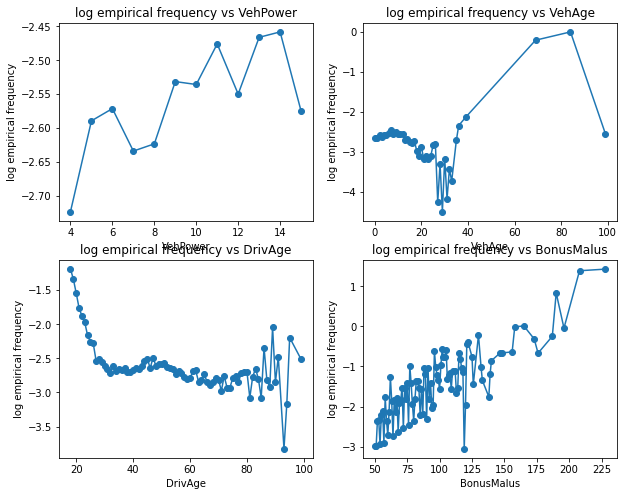

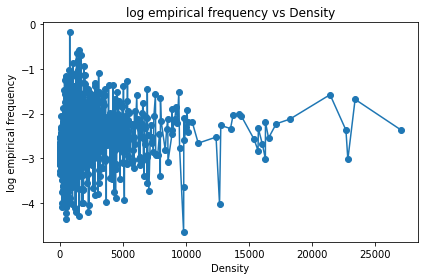

<Figure size 432x288 with 0 Axes>

In [3]:
import matplotlib.pyplot as plt

# -------- NUMERIC/DISCRETE FEATURES --------
fig, axes = plt.subplots(2, 2, figsize=(10, 8))
axes = axes.flatten()   # easier indexing: axes[0], ..., axes[3]

for i, col in enumerate(num_cols):
    unique_vals = np.sort(data[col].unique())

    x_vals = []
    log_freq_vals = []

    for v in unique_vals:
        mask = (data[col] == v)
        total_claims = data.loc[mask, "ClaimNb"].sum()
        total_exposure = data.loc[mask, "Exposure"].sum()

        if total_exposure <= 1e-6:
            continue

        lam_hat = total_claims / total_exposure
        if lam_hat <= 0:
            continue

        x_vals.append(v)
        log_freq_vals.append(np.log(lam_hat))

    # First 4 plots go into the 2x2 grid
    if i < 4:
        ax = axes[i]
        ax.plot(x_vals, log_freq_vals, marker="o")
        ax.set_xlabel(col)
        ax.set_ylabel("log empirical frequency")
        ax.set_title(f"log empirical frequency vs {col}")
    else:
        # 5th (and any later ones) get their own standalone figure
        plt.figure(figsize=(6, 4))
        plt.plot(x_vals, log_freq_vals, marker="o")
        plt.xlabel(col)
        plt.ylabel("log empirical frequency")
        plt.title(f"log empirical frequency vs {col}")
        plt.tight_layout()
        plt.show()

# Show the 2x2 grid
plt.tight_layout()
plt.show()

In [4]:
# Propose feature transformations. Justify your choices

x_fe = x.copy()

# --- DrivAge^2 as numeric feature ---
x_fe["DrivAge2"] = x_fe["DrivAge"]**2

# --- VehAge as categorical bands ---
bins   = [0, 1, 5, 10, 20, np.inf]
labels = ["0-1", "2-5", "6-10", "11-20", ">20"]

x_fe["VehAgeCat"] = pd.cut(
    x_fe["VehAge"],
    bins=bins,
    labels=labels,
    include_lowest=True,
    right=True
).astype("category")

# Drop raw VehAge and Density (we don't want them in the model anymore)
x_fe = x_fe.drop(columns=["VehAge", "Density"])

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.linear_model import PoissonRegressor
import numpy as np

# Train-test split (note x_fe instead of x)
x_train, x_test, claims_train, claims_test, exp_train, exp_test = train_test_split(
    x_fe, claims, exposure,
    test_size=0.1,
    random_state=42
)

# Categorical vs numerical columns (VehAgeCat will be categorical, DrivAge2 numeric)
categoric_columns = x_train.select_dtypes(include=["object", "category"]).columns.tolist()
num_cols = [c for c in x_train.columns if c not in categoric_columns]

print("Categoric columns in the dataset : ", categoric_columns, "\n")
print("Numerical columns in the dataset : ", num_cols)

# One-Hot encoding of categorical data
ohe = OneHotEncoder(handle_unknown="ignore", sparse_output=False)
ohe.fit(x_train[categoric_columns])

X_train_cat = ohe.transform(x_train[categoric_columns])
X_test_cat  = ohe.transform(x_test[categoric_columns])

# Scaling numerical variables (includes DrivAge2)
scaler_x = StandardScaler()
scaler_x.fit(x_train[num_cols])

X_train_num = scaler_x.transform(x_train[num_cols])
X_test_num  = scaler_x.transform(x_test[num_cols])

# Combine
X_train_enc = np.hstack([X_train_num, X_train_cat])
X_test_enc  = np.hstack([X_test_num, X_test_cat])

# Frequencies as target
y_train = claims_train / exp_train
y_test  = claims_test / exp_test

# Poisson GLM
model_PR = PoissonRegressor(alpha=0, fit_intercept=True)
model_PR.fit(X_train_enc, y_train, sample_weight=exp_train)

# Predictions
y_pred_train = model_PR.predict(X_train_enc)
y_pred_test  = model_PR.predict(X_test_enc)

# Exposure-weighted Poisson deviance (Equation 2)
def weighted_poisson_deviance(y_true, y_pred, exposure):
    """
    L(D, θ̂) = 1 / sum(exp_i) * sum_i exp_i * ℓ(λ̂_i, y_i)
    with ℓ(λ̂, y) = 2(λ̂ - y - y log λ̂ + y log y)
    and convention 0*log(0) = 0
    """
    # Numerical stability
    y_pred = np.clip(y_pred, 1e-15, None)

    # Handle y log y term with convention 0 log 0 = 0
    y_true_safe = np.where(y_true > 0, y_true, 1.0)

    deviance = 2 * (
        y_pred - y_true
        - y_true * np.log(y_pred)
        + y_true * np.log(y_true_safe)
    )

    # Explicit handling for y = 0
    deviance = np.where(y_true > 0, deviance, 2 * y_pred)

    # Exposure-weighted average
    return np.sum(exposure * deviance) / np.sum(exposure)

# Compute MAE, MSE, and Loss L on train/test
mae_train = mean_absolute_error(y_train, y_pred_train, sample_weight=exp_train)
mse_train = mean_squared_error(y_train, y_pred_train, sample_weight=exp_train)
loss_train = weighted_poisson_deviance(y_train, y_pred_train, exp_train)

mae_test = mean_absolute_error(y_test, y_pred_test, sample_weight=exp_test)
mse_test = mean_squared_error(y_test, y_pred_test, sample_weight=exp_test)
loss_test = weighted_poisson_deviance(y_test, y_pred_test, exp_test)

print("\n--- Question 1.c: Poisson GLM with feature transformations ---")
print(f"Train set - MAE: {mae_train:.5f}, MSE: {mse_train:.5f}, Loss L: {loss_train:.5f}")
print(f"Test set  - MAE: {mae_test:.5f}, MSE: {mse_test:.5f}, Loss L: {loss_test:.5f}")

Categoric columns in the dataset :  ['VehBrand', 'VehGas', 'Region', 'VehAgeCat'] 

Numerical columns in the dataset :  ['VehPower', 'DrivAge', 'BonusMalus', 'DrivAge2']

--- Question 1.c: Poisson GLM with feature transformations ---
Train set - MAE: 0.13829, MSE: 0.23562, Loss L: 0.45909
Test set  - MAE: 0.13636, MSE: 0.25550, Loss L: 0.45067


### Question 1.c

In [33]:
# Train a Poisson GLM using your feature transformations

# Print MAE, MSE and loss on train and test data sets

# Make sure your model outperforms the model of Question 1.a

# Exercise 2 (Poisson FNN)

In [5]:
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split


device = "cuda" if torch.cuda.is_available() else "cpu"
print("Device:", device)


X_train_t = torch.tensor(X_train_enc.astype(np.float32), device=device)
X_test_t  = torch.tensor(X_test_enc.astype(np.float32),  device=device)

y_train_freq = y_train.to_numpy().astype(np.float32)
y_test_freq  = y_test.to_numpy().astype(np.float32)

y_train_t = torch.tensor(y_train_freq, device=device).view(-1, 1)
y_test_t  = torch.tensor(y_test_freq,  device=device).view(-1, 1)

exp_train_t = torch.tensor(exp_train.to_numpy().astype(np.float32), device=device).view(-1, 1)
exp_test_t  = torch.tensor(exp_test.to_numpy().astype(np.float32),  device=device).view(-1, 1)

# Loss: Exposure-weighted Poisson deviance (Eq. 2)
def exposure_weighted_poisson_deviance(y, lam_hat, exposure, eps=1e-15):
    lam_hat = torch.clamp(lam_hat, min=eps)
    y_safe = torch.where(y > 0, y, torch.ones_like(y))  # for y log y with 0*log(0)=0

    per_obs = 2.0 * (lam_hat - y - y * torch.log(lam_hat) + y * torch.log(y_safe))
    # For y=0, formula reduces to 2*lam_hat automatically (since y terms vanish and y_safe unused)
    return (exposure * per_obs).sum() / exposure.sum()

# Metrics: exposure-weighted MAE/MSE
def weighted_mae(y, yhat, w):
    return (w * (y - yhat).abs()).sum() / w.sum()

def weighted_mse(y, yhat, w):
    return (w * (y - yhat).pow(2)).sum() / w.sum()

# Model: starter architecture from 2(a)
class PoissonFFN(nn.Module):
    def __init__(self, input_size, hidden_size=20):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_size, hidden_size), nn.ReLU(),
            nn.Linear(hidden_size, hidden_size), nn.ReLU(),
            nn.Linear(hidden_size, 1)
        )

    def forward(self, x):
        # exponential output to ensure positivity
        return torch.exp(self.net(x))

input_size = X_train_enc.shape[1]

# Train loop (mini-batch)
def train_one_model(X_tr, y_tr, w_tr, X_val, y_val, w_val,
                    hidden_size=20, lr=0.01, weight_decay=0.0,
                    batch_size=10_000, num_epochs=100, verbose=False):

    model = PoissonFFN(input_size=X_tr.shape[1], hidden_size=hidden_size).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)

    train_loader = DataLoader(
        TensorDataset(X_tr, y_tr, w_tr),
        batch_size=batch_size,
        shuffle=True
    )

    best_val_loss = float("inf")
    best_state = None

    for epoch in range(num_epochs):
        model.train()
        for xb, yb, wb in train_loader:
            optimizer.zero_grad()
            lam_hat = model(xb)
            loss = exposure_weighted_poisson_deviance(yb, lam_hat, wb)
            loss.backward()
            optimizer.step()

        # validation each epoch
        model.eval()
        with torch.no_grad():
            lam_val = model(X_val)
            val_loss = exposure_weighted_poisson_deviance(y_val, lam_val, w_val).item()

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_state = {k: v.detach().cpu().clone() for k, v in model.state_dict().items()}

        if verbose and (epoch + 1) % 10 == 0:
            print(f"Epoch {epoch+1:3d} | val L = {val_loss:.5f}")

    # load best weights
    model.load_state_dict(best_state)
    return model, best_val_loss

# Simple CV for L2 (weight decay) on training set
# Holdout validation split inside the training set
idx = np.arange(X_train_enc.shape[0])
idx_tr, idx_val = train_test_split(idx, test_size=0.1, random_state=42)

X_tr, y_tr, w_tr = X_train_t[idx_tr], y_train_t[idx_tr], exp_train_t[idx_tr]
X_val, y_val, w_val = X_train_t[idx_val], y_train_t[idx_val], exp_train_t[idx_val]

weight_decay_grid = [0.0, 1e-6, 1e-5, 1e-4, 1e-3]

best_wd = None
best_val = float("inf")
best_model = None

for wd in weight_decay_grid:
    model_tmp, val_loss = train_one_model(
        X_tr, y_tr, w_tr,
        X_val, y_val, w_val,
        hidden_size=20,
        lr=0.01,
        weight_decay=wd,
        batch_size=10_000,
        num_epochs=100,
        verbose=False
    )
    print(f"weight_decay={wd:<7g} | val Loss L = {val_loss:.5f}")
    if val_loss < best_val:
        best_val = val_loss
        best_wd = wd
        best_model = model_tmp

print(f"\nSelected weight_decay (L2): {best_wd} with val Loss L = {best_val:.5f}")

# Final evaluation on full train/test with selected model
best_model.eval()
with torch.no_grad():
    lam_train = best_model(X_train_t)
    lam_test  = best_model(X_test_t)

    L_train = exposure_weighted_poisson_deviance(y_train_t, lam_train, exp_train_t).item()
    L_test  = exposure_weighted_poisson_deviance(y_test_t,  lam_test,  exp_test_t).item()

    mae_train = weighted_mae(y_train_t, lam_train, exp_train_t).item()
    mse_train = weighted_mse(y_train_t, lam_train, exp_train_t).item()

    mae_test = weighted_mae(y_test_t, lam_test, exp_test_t).item()
    mse_test = weighted_mse(y_test_t, lam_test, exp_test_t).item()

print("\n--- Exercise 2: Poisson Feedforward Neural Network ---")
print(f"Train set - MAE: {mae_train:.5f}, MSE: {mse_train:.5f}, Loss L: {L_train:.5f}")
print(f"Test set  - MAE: {mae_test:.5f}, MSE: {mse_test:.5f}, Loss L: {L_test:.5f}")

Device: cpu
weight_decay=0       | val Loss L = 0.45551
weight_decay=1e-06   | val Loss L = 0.45596
weight_decay=1e-05   | val Loss L = 0.45536
weight_decay=0.0001  | val Loss L = 0.45480
weight_decay=0.001   | val Loss L = 0.45545

Selected weight_decay (L2): 0.0001 with val Loss L = 0.45480

--- Exercise 2: Poisson Feedforward Neural Network ---
Train set - MAE: 0.13707, MSE: 0.23441, Loss L: 0.45132
Test set  - MAE: 0.13483, MSE: 0.25401, Loss L: 0.44247


### Question 2.a

In [ ]:
# Neural network implementation

### Question 2.b

In [ ]:
# Train Poisson feedforward neural network model

# Print MAE, MSE and loss on train and test data sets

# Make sure your model outperforms the Poisson GLM model of Question 1.b.

# Exercise 3 (Tree-based methods)

In [37]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import KFold
from sklearn.metrics import mean_absolute_error, mean_squared_error

from sklearn.ensemble import RandomForestRegressor

from sklearn.ensemble import HistGradientBoostingRegressor






### Question 3.a

In [26]:
num_features = ["VehPower", "VehAge", "DrivAge", "BonusMalus", "Density"]
cat_features = ["VehBrand", "VehGas", "Region"]

preprocess = ColumnTransformer(
    transformers=[
        ("num", "passthrough", num_features),
        ("cat", OneHotEncoder(handle_unknown="ignore"), cat_features),
    ]
)

In [ ]:
tree = DecisionTreeRegressor(
    criterion="poisson",     
    min_samples_leaf=50,      #to limit overfit
    random_state=0
)

In [28]:
model = Pipeline(steps=[
    ("preprocess", preprocess),
    ("regressor", tree)
])

In [29]:
model.fit(x_train, y_train, regressor__sample_weight=exp_train)

,steps,"[('preprocess', ...), ('regressor', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('num', ...), ('cat', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


In [30]:


grid = [0.0,1e-6, 1e-5, 1e-4, 1e-3, 1e-2 ]

kf = KFold(n_splits=3, shuffle=True, random_state=0)

cv_results = []

for mid in grid:
    fold_losses = []
    for train_idx, val_idx in kf.split(x_train):
        X_tr, X_val = x_train.iloc[train_idx], x_train.iloc[val_idx]
        y_tr, y_val = y_train.iloc[train_idx], y_train.iloc[val_idx]
        exp_tr, exp_val = exp_train.iloc[train_idx], exp_train.iloc[val_idx]

        tree = DecisionTreeRegressor(
            criterion="poisson",
            min_impurity_decrease=mid,
            min_samples_leaf=50,      # to limit overfit
            random_state=0
        )

        model = Pipeline(steps=[
            ("preprocess", preprocess),
            ("regressor", tree),
        ])

        model.fit(X_tr, y_tr, regressor__sample_weight=exp_tr)

        y_val_pred = model.predict(X_val)
        loss_val = weighted_poisson_deviance(y_val, y_val_pred, exp_val)
        fold_losses.append(loss_val)

    mean_loss = np.mean(fold_losses)
    cv_results.append((mid, mean_loss))
    print(f"min_impurity_decrease={mid:.0e} -> mean CV Poisson deviance = {mean_loss:.4f}")

best_mid, best_loss = min(cv_results, key=lambda t: t[1])
print("\nBest min_impurity_decrease:", best_mid, "with mean CV loss:", best_loss)

min_impurity_decrease=0e+00 -> mean CV Poisson deviance = 0.5286
min_impurity_decrease=1e-06 -> mean CV Poisson deviance = 0.5283
min_impurity_decrease=1e-05 -> mean CV Poisson deviance = 0.4680
min_impurity_decrease=1e-04 -> mean CV Poisson deviance = 0.4548
min_impurity_decrease=1e-03 -> mean CV Poisson deviance = 0.4616
min_impurity_decrease=1e-02 -> mean CV Poisson deviance = 0.4783

Best min_impurity_decrease: 0.0001 with mean CV loss: 0.4547614133329498


In [31]:
best_tree = DecisionTreeRegressor(
    criterion="poisson",
    min_impurity_decrease=best_mid,
    min_samples_leaf=50,
    random_state=0
)

best_model = Pipeline(steps=[
    ("preprocess", preprocess),
    ("regressor", best_tree),
])

best_model.fit(x_train, y_train, regressor__sample_weight=exp_train)


,steps,"[('preprocess', ...), ('regressor', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('num', ...), ('cat', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


In [32]:
y_pred_train = best_model.predict(x_train)
y_pred_test  = best_model.predict(x_test)


mae_train = mean_absolute_error(y_train, y_pred_train)
mse_train = mean_squared_error(y_train, y_pred_train)
L_train   = weighted_poisson_deviance(y_train, y_pred_train, exp_train)


mae_test = mean_absolute_error(y_test, y_pred_test)
mse_test = mean_squared_error(y_test, y_pred_test)
L_test   = weighted_poisson_deviance(y_test, y_pred_test, exp_test)

print("\n=== Train ===")
print(f"MAE: {mae_train:.6f}")
print(f"MSE: {mse_train:.6f}")
print(f"Poisson deviance (L): {L_train:.6f}")

print("\n=== Test ===")
print(f"MAE: {mae_test:.6f}")
print(f"MSE: {mse_test:.6f}")
print(f"Poisson deviance (L): {L_test:.6f}")



=== Train ===
MAE: 0.187520
MSE: 3.855461
Poisson deviance (L): 0.453908

=== Test ===
MAE: 0.199813
MSE: 5.386708
Poisson deviance (L): 0.442557


### Question 3.b

In [33]:

min_impurity_grid = [0.0, 1e-3, 1e-2]
                     
max_features_grid = ["sqrt", "log2",  0.5] 

kf = KFold(n_splits=3, shuffle=True, random_state=0)

best_cfg = None
best_loss = np.inf
cv_results = []


for mid in min_impurity_grid:
    for mf in max_features_grid:
        fold_losses = []

        for train_idx, val_idx in kf.split(x_train):

            X_tr, X_val = x_train.iloc[train_idx], x_train.iloc[val_idx]
            y_tr, y_val = y_train.iloc[train_idx], y_train.iloc[val_idx]
            exp_tr, exp_val = exp_train.iloc[train_idx], exp_train.iloc[val_idx]


            rf = RandomForestRegressor(
                n_estimators=100,
                criterion="poisson",
                min_impurity_decrease=mid,
                max_features=mf,
                min_samples_leaf=50,   # to limit l'overfit
                n_jobs=-1,
                random_state=0
            )

            model = Pipeline(steps=[
                ("preprocess", preprocess),
                ("regressor", rf),
            ])


            model.fit(X_tr, y_tr, regressor__sample_weight=exp_tr)

            y_val_pred = model.predict(X_val)
            loss_val = weighted_poisson_deviance(y_val, y_val_pred, exp_val)
            fold_losses.append(loss_val)

        mean_loss = np.mean(fold_losses)
        cv_results.append((mid, mf, mean_loss))
        print(f"min_impurity_decrease={mid:.0e}, max_features={mf} "
              f"-> mean CV Poisson deviance = {mean_loss:.4f}")

        if mean_loss < best_loss:
            best_loss = mean_loss
            best_cfg = (mid, mf)

best_mid, best_mf = best_cfg
print("\nBest config:")
print(f"  min_impurity_decrease = {best_mid}")
print(f"  max_features          = {best_mf}")
print(f"  mean CV loss          = {best_loss:.4f}")


best_rf = RandomForestRegressor(
    n_estimators=100,
    criterion="poisson",
    min_impurity_decrease=best_mid,
    max_features=best_mf,
    min_samples_leaf=50,
    n_jobs=-1,
    random_state=0
)

best_model_rf = Pipeline(steps=[
    ("preprocess", preprocess),
    ("regressor", best_rf),
])

best_model_rf.fit(x_train, y_train, regressor__sample_weight=exp_train)


y_pred_train = best_model_rf.predict(x_train)
y_pred_test  = best_model_rf.predict(x_test)


mae_train = mean_absolute_error(y_train, y_pred_train)
mse_train = mean_squared_error(y_train, y_pred_train)
L_train   = weighted_poisson_deviance(y_train, y_pred_train, exp_train)


mae_test = mean_absolute_error(y_test, y_pred_test)
mse_test = mean_squared_error(y_test, y_pred_test)
L_test   = weighted_poisson_deviance(y_test, y_pred_test, exp_test)

print("\n=== RandomForest Poisson - Train ===")
print(f"MAE: {mae_train:.6f}")
print(f"MSE: {mse_train:.6f}")
print(f"Poisson deviance (L): {L_train:.6f}")

print("\n=== RandomForest Poisson - Test ===")
print(f"MAE: {mae_test:.6f}")
print(f"MSE: {mse_test:.6f}")
print(f"Poisson deviance (L): {L_test:.6f}")


min_impurity_decrease=0e+00, max_features=sqrt -> mean CV Poisson deviance = 0.4520
min_impurity_decrease=0e+00, max_features=log2 -> mean CV Poisson deviance = 0.4526
min_impurity_decrease=0e+00, max_features=0.5 -> mean CV Poisson deviance = 0.4528
min_impurity_decrease=1e-03, max_features=sqrt -> mean CV Poisson deviance = 0.4720
min_impurity_decrease=1e-03, max_features=log2 -> mean CV Poisson deviance = 0.4736
min_impurity_decrease=1e-03, max_features=0.5 -> mean CV Poisson deviance = 0.4626
min_impurity_decrease=1e-02, max_features=sqrt -> mean CV Poisson deviance = 0.4783
min_impurity_decrease=1e-02, max_features=log2 -> mean CV Poisson deviance = 0.4783
min_impurity_decrease=1e-02, max_features=0.5 -> mean CV Poisson deviance = 0.4783

Best config:
  min_impurity_decrease = 0.0
  max_features          = sqrt
  mean CV loss          = 0.4520

=== RandomForest Poisson - Train ===
MAE: 0.186824
MSE: 3.849801
Poisson deviance (L): 0.419068

=== RandomForest Poisson - Test ===
MAE: 

### Question 3.c

In [ ]:
learning_rate_grid = [0.01, 0.05, 0.1 ]
n_estimators_grid  = [50,100,200  ]

kf = KFold(n_splits=3, shuffle=True, random_state=0)

best_cfg = None
best_loss = np.inf
cv_results = []

preprocess = ColumnTransformer(
    transformers=[
        ("num", "passthrough", num_features),
        ("cat", OneHotEncoder(handle_unknown="ignore", sparse_output=False), cat_features),
    ]
)

for lr in learning_rate_grid:
    for n_est in n_estimators_grid:
        fold_losses = []

        for train_idx, val_idx in kf.split(x_train):
            X_tr, X_val = x_train.iloc[train_idx], x_train.iloc[val_idx]
            y_tr, y_val = y_train.iloc[train_idx], y_train.iloc[val_idx]
            exp_tr, exp_val = exp_train.iloc[train_idx], exp_train.iloc[val_idx]

            gbr = HistGradientBoostingRegressor(
                loss="poisson",
                learning_rate=lr,
                max_iter=n_est,
                max_depth=3,         
                random_state=0
            )

            model = Pipeline(steps=[
                ("preprocess", preprocess),
                ("regressor", gbr),
            ])


            model.fit(X_tr, y_tr, regressor__sample_weight=exp_tr)

            y_val_pred = model.predict(X_val)
            loss_val = weighted_poisson_deviance(y_val, y_val_pred, exp_val)
            fold_losses.append(loss_val)

        mean_loss = np.mean(fold_losses)
        cv_results.append((lr, n_est, mean_loss))
        print(f"learning_rate={lr}, n_estimators={n_est} "
              f"-> mean CV Poisson deviance = {mean_loss:.4f}")

        if mean_loss < best_loss:
            best_loss = mean_loss
            best_cfg = (lr, n_est)

best_lr, best_n_est = best_cfg
print("\nBest config:")
print(f"  learning_rate = {best_lr}")
print(f"  n_estimators  = {best_n_est}")
print(f"  mean CV loss  = {best_loss:.4f}")


best_gbr = HistGradientBoostingRegressor(
    loss="poisson",
    learning_rate=best_lr,
    max_iter=best_n_est,
    max_depth=3,
    random_state=0
)

best_model_gbr = Pipeline(steps=[
    ("preprocess", preprocess),
    ("regressor", best_gbr),
])

best_model_gbr.fit(x_train, y_train, regressor__sample_weight=exp_train)


y_pred_train = best_model_gbr.predict(x_train)
y_pred_test  = best_model_gbr.predict(x_test)


mae_train = mean_absolute_error(y_train, y_pred_train)
mse_train = mean_squared_error(y_train, y_pred_train)
L_train   = weighted_poisson_deviance(y_train, y_pred_train, exp_train)

mae_test = mean_absolute_error(y_test, y_pred_test)
mse_test = mean_squared_error(y_test, y_pred_test)
L_test   = weighted_poisson_deviance(y_test, y_pred_test, exp_test)

print("\n=== Gradient Boosted Trees (Poisson) - Train ===")
print(f"MAE: {mae_train:.6f}")
print(f"MSE: {mse_train:.6f}")
print(f"Poisson deviance (L): {L_train:.6f}")

print("\n=== Gradient Boosted Trees (Poisson) - Test ===")
print(f"MAE: {mae_test:.6f}")
print(f"MSE: {mse_test:.6f}")
print(f"Poisson deviance (L): {L_test:.6f}")


learning_rate=0.01, n_estimators=50 -> mean CV Poisson deviance = 0.4634
learning_rate=0.01, n_estimators=100 -> mean CV Poisson deviance = 0.4581
learning_rate=0.01, n_estimators=200 -> mean CV Poisson deviance = 0.4541
learning_rate=0.05, n_estimators=50 -> mean CV Poisson deviance = 0.4532
learning_rate=0.05, n_estimators=100 -> mean CV Poisson deviance = 0.4512
learning_rate=0.05, n_estimators=200 -> mean CV Poisson deviance = 0.4502
learning_rate=0.1, n_estimators=50 -> mean CV Poisson deviance = 0.4512
learning_rate=0.1, n_estimators=100 -> mean CV Poisson deviance = 0.4503
learning_rate=0.1, n_estimators=200 -> mean CV Poisson deviance = 0.4495

Best config:
  learning_rate = 0.1
  n_estimators  = 200
  mean CV loss  = 0.4495

=== Gradient Boosted Trees (Poisson) - Train ===
MAE: 0.186917
MSE: 3.854241
Poisson deviance (L): 0.445334

=== Gradient Boosted Trees (Poisson) - Test ===
MAE: 0.199353
MSE: 5.386019
Poisson deviance (L): 0.436277
